## Importacion de datos

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.reset_option("display.max_rows")
pd.set_option('display.max_columns', None)
filename = 'au_recuperacion.csv'

df = pd.read_csv(filename)
df

,toneladas,ag_cabeza,ag_concentrado_pb,ag_colas_pb,ag_concentrado_zn,toneladas_lag1,toneladas_lag2,toneladas_lag4,toneladas_lag5,ag_cabeza_lag3,ag_cabeza_lag4,ag_cabeza_lag5,ag_concentrado_pb_lag1,ag_concentrado_pb_lag2,ag_concentrado_pb_lag3,ag_concentrado_pb_lag4,ag_concentrado_pb_lag5,ag_colas_pb_lag1,ag_contenido_lag2,ag_contenido_lag4,ag_concentrado_pb_ley_lag1,ag_concentrado_pb_ley_lag2,ag_concentrado_pb_ley_lag5,ag_concentrado_zn_ley_lag1,ag_concentrado_zn_ley_lag2,ag_concentrado_zn_ley_lag4,au_recuperacion
0,1955.000000,386.735035,11759.800086,66.443588,36.363671,1736.900000,1940.495344,1864.900000,2000.140000,433.563890,392.759944,380.996754,13680.600737,14210.709223,10849.754580,14678.875568,15521.465281,69.005223,679.476618,595.668981,13680.600737,14210.709223,15521.465281,861.327000,139.982938,1113.354178,45.261454
1,2068.400000,308.403662,11202.412270,42.605099,38.181474,1955.000000,1736.900000,1940.495344,1864.900000,395.809007,433.563890,392.759944,11759.800086,13680.600737,14210.709223,10849.754580,14678.875568,66.443588,515.812824,776.004439,11759.800086,13680.600737,14678.875568,557.964092,861.327000,879.189666,54.807118
2,1857.100000,286.730210,9597.114412,53.813036,35.682764,2068.400000,1955.000000,1940.495344,1940.495344,350.598152,395.809007,433.563890,11202.412270,11759.800086,13680.600737,14210.709223,10849.754580,42.605099,648.226606,679.476618,11202.412270,11759.800086,10849.754580,83.998345,557.964092,139.982938,53.258471
3,1864.900000,240.906421,8868.919123,61.443754,35.312051,1857.100000,2068.400000,1736.900000,1940.495344,386.735035,350.598152,395.809007,9597.114412,11202.412270,11759.800086,13680.600737,14210.709223,53.813036,498.468808,515.812824,9597.114412,11202.412270,14210.709223,230.235234,83.998345,861.327000,40.685627
4,2079.700000,344.147401,8648.474523,86.746429,46.192024,1864.900000,1857.100000,1955.000000,1736.900000,308.403662,386.735035,350.598152,8868.919123,9597.114412,11202.412270,11759.800086,13680.600737,61.443754,434.227205,648.226606,8868.919123,9597.114412,13680.600737,467.366411,230.235234,557.964092,48.646052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,1985.050617,362.257465,14042.119654,81.631983,68.454396,1979.603954,2113.890245,2071.680000,2040.122739,452.079926,460.034279,472.683192,12818.611854,12355.752802,11407.257492,11849.699751,10601.251207,120.224803,860.155499,760.269374,12818.611854,12355.752802,10601.251207,1046.866754,990.095218,143.624778,56.684907
540,2080.121574,330.719970,9284.179992,101.999364,43.441612,1985.050617,1979.603954,1763.482552,2071.680000,507.709743,452.079926,460.034279,14042.119654,12818.611854,12355.752802,11407.257492,11849.699751,81.631983,695.758224,650.373972,14042.119654,12818.611854,11849.699751,108.428829,1046.866754,998.942805,36.643490
541,2012.237300,414.169898,10421.821378,95.588347,49.714671,2080.121574,1985.050617,2113.890245,1763.482552,477.161339,507.709743,452.079926,9284.179992,14042.119654,12818.611854,12355.752802,11407.257492,101.999364,545.745002,860.155499,9284.179992,14042.119654,11407.257492,1140.314163,108.428829,990.095218,46.164865
542,2040.413769,510.265139,17600.328876,95.426258,73.589515,2012.237300,2080.121574,1979.603954,2113.890245,362.257465,477.161339,507.709743,10421.821378,9284.179992,14042.119654,12818.611854,12355.752802,95.588347,473.914130,695.758224,10421.821378,9284.179992,12355.752802,440.549101,1140.314163,1046.866754,37.291719


In [280]:
def train_val_test_split(df, tr_size=0.8, vl_size=0.1, ts_size=0.1):
    #Definimos el numero de datos en cada subserie
    N = df.shape[0]
    Ntrain = int(tr_size*N)
    Nval = int(vl_size*N)
    Ntst = N - Ntrain - Nval

    # Realizar particion
    train = df[0:Ntrain]
    val = df[Ntrain:Ntrain+Nval]
    test = df[Ntrain+Nval:]

    return train, val, test

In [282]:
tr, vl, ts = train_val_test_split(df)
print(f"tam set de entrenamiento: {tr.shape}")
print(f"tam set de validacion: {vl.shape}")
print(f"tam set de test: {ts.shape}")

tam set de entrenamiento: (435, 27)
tam set de validacion: (54, 27)
tam set de test: (55, 27)


In [284]:
import numpy as np

def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [286]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 14   # Hiperparámetro
OUTPUT_LENGTH = 4    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (417, 14, 27), y_tr: (417, 4, 1)
Set de validación - x_vl: (36, 14, 27), y_vl: (36, 4, 1)
Set de prueba - x_ts: (37, 14, 27), y_ts: (37, 4, 1)


In [288]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [290]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'au_recuperacion' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

ValueError: The number of FixedLocator locations (13), usually from a call to set_ticks, does not match the number of labels (27).

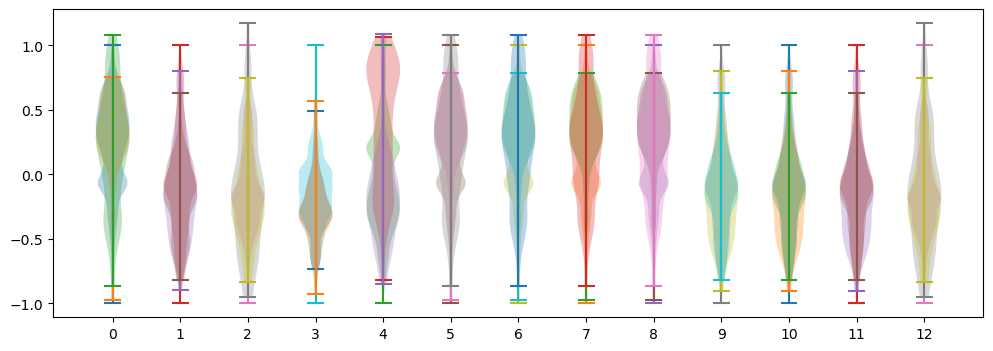

In [294]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(13):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(13)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

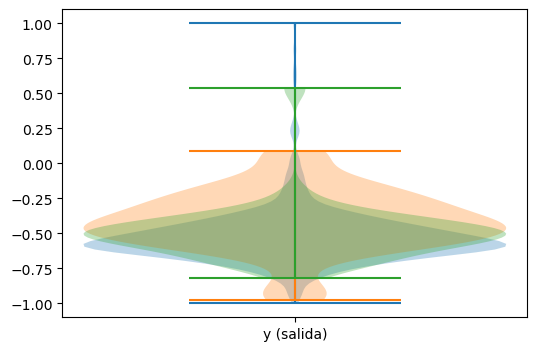

In [297]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

## Entrenamiento del Modelo

In [300]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 5 dias x 45 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/100


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 2s - 977ms/step - loss: 0.5329 - val_loss: 0.3483
Epoch 2/100
2/2 - 0s - 72ms/step - loss: 0.3869 - val_loss: 0.2981
Epoch 3/100
2/2 - 0s - 71ms/step - loss: 0.3013 - val_loss: 0.3057
Epoch 4/100
2/2 - 0s - 70ms/step - loss: 0.2570 - val_loss: 0.3138
Epoch 5/100
2/2 - 0s - 71ms/step - loss: 0.2385 - val_loss: 0.3067
Epoch 6/100
2/2 - 0s - 70ms/step - loss: 0.2310 - val_loss: 0.2924
Epoch 7/100
2/2 - 0s - 68ms/step - loss: 0.2278 - val_loss: 0.2803
Epoch 8/100
2/2 - 0s - 69ms/step - loss: 0.2251 - val_loss: 0.2719
Epoch 9/100
2/2 - 0s - 69ms/step - loss: 0.2222 - val_loss: 0.2644
Epoch 10/100
2/2 - 0s - 67ms/step - loss: 0.2201 - val_loss: 0.2569
Epoch 11/100
2/2 - 0s - 67ms/step - loss: 0.2187 - val_loss: 0.2499
Epoch 12/100
2/2 - 0s - 67ms/step - loss: 0.2179 - val_loss: 0.2440
Epoch 13/100
2/2 - 0s - 67ms/step - loss: 0.2173 - val_loss: 0.2396
Epoch 14/100
2/2 - 0s - 72ms/step - loss: 0.2166 - val_loss: 0.2363
Epoch 15/100
2/2 - 0s - 74ms/step - loss: 0.2159 - val_loss: 0.2338


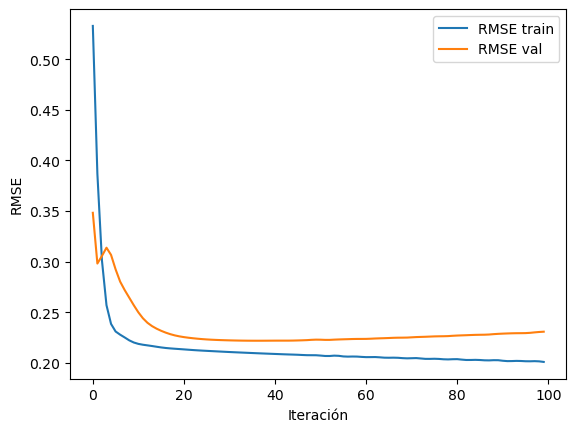

In [302]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

## Evaluacion del modelo

In [305]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.186
  RMSE val:	 0.226
  RMSE test:	 0.236


Forma de y_ts_s: (37, 4, 1)
Forma de y_ts_pred_s: (37, 4)


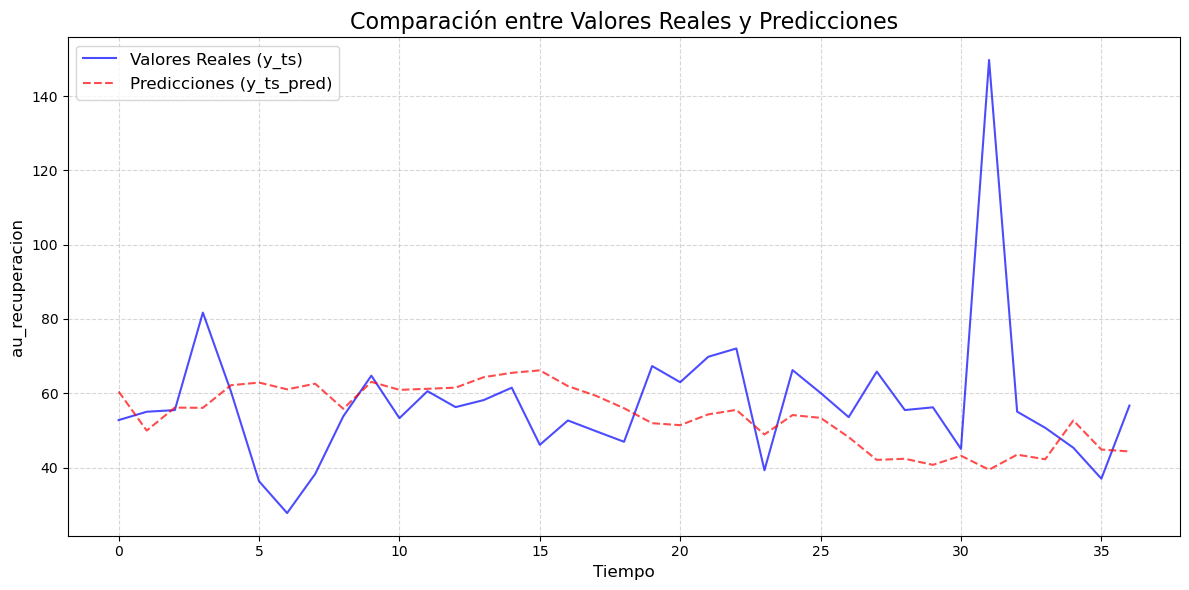

In [307]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Verificar las formas de los arrays
print(f"Forma de y_ts_s: {y_ts_s.shape}")
print(f"Forma de y_ts_pred_s: {y_ts_pred_s.shape}")

# 3. Ajustar las formas si es necesario
if len(y_ts_s.shape) == 3:
    y_ts_s = np.squeeze(y_ts_s, axis=-1)
if len(y_ts_pred_s.shape) == 3:
    y_ts_pred_s = np.squeeze(y_ts_pred_s, axis=-1)

# 4. Realizar la transformación inversa de las predicciones
y_ts_original = scaler.inverse_transform(y_ts_s)
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 5. Graficar los datos de prueba y las predicciones
plt.figure(figsize=(12, 6))

# Graficar los datos de prueba (valores reales)
plt.plot(y_ts_original[:, 0], label='Valores Reales (y_ts)', color='blue', alpha=0.7)

# Graficar las predicciones del modelo
plt.plot(y_ts_pred[:, 0], label='Predicciones (y_ts_pred)', color='red', linestyle='--', alpha=0.7)

# Personalizar la gráfica
plt.title('Comparación entre Valores Reales y Predicciones', fontsize=16)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('au_recuperacion', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [309]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'MSE: {mse}')

MSE: 0.05796326801201974


In [311]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'MAE: {mae}')

MAE: 0.14836853526177005


In [317]:
from sklearn.metrics import r2_score

r2 = r2_score(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'R²: {r2}')

R²: -0.28437608974762596


In [319]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'MAPE: {mape}%')

MAPE: 30.419726552721205%
